# tokenize

> Fill in a module description here

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp tokenize

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import json

import faiss
import pandas as pd
from fastai.vision.all import *

from singleline_stroke3.embeddings import *
from singleline_stroke3.display import *
from singleline_stroke3.transforms import *
from singleline_stroke3.fileorg import *

In [ ]:
EXTERNAL_PARENT_DIR = Path('/Users/al/Dropbox/2-Areas/2-Sketchbooks')
EXTERNAL_SKETCHBOOKS_DIR = EXTERNAL_PARENT_DIR / 'sketchbooks'
EXTERNAL_DATA_HOME = EXTERNAL_PARENT_DIR / 'singleline_data'

EPOCH = SketchbookEpoch(epoch='20240104', data_home=EXTERNAL_DATA_HOME)

no env var SINGLELINE_DATA_HOME, defaulting to: None


In [ ]:
THRESHOLDED_OUTPUT_DIR = EPOCH.dir_08_THRESHOLDED()
THESHOLDED_TSV_FNAME = EPOCH.tsv_08_THRESHOLDED()
fjdf = pd.read_csv(THESHOLDED_TSV_FNAME, delimiter="\t", index_col="idx")
fjdf.head()

,new_idx,group_fname,group_id,group_num_strokes,group_num_points,indiv_fnamebboxsep_,orig_fname,labelbboxsep_,handlabeled_path,is_new,...,err_msg,indiv_fname,label,emb_csv,knn_dist,knn_clusterid,knn_label,cluster_label,rdp_num_points,rdp_epsilon
idx,,,,,,,,,,,,,,,,,,,,,
0,0,0_drawings/sb55p003g00.png,0,4,1510,sb55p003.jpg,art/sb55p003.jpg,art,0_drawings/sb55p003.jpg,False,...,NaN,sb55p003g00.png,0_drawings,"0.04728329,-0.5714155,-0.73929733,-0.35399058,0.22400337,-0.65341413,0.11710799,-0.4896673,-0.7537334,-0.27084306,-0.43680793,-0.72562873,0.26104796,-0.6266761,-0.68991846,-0.57515705,-0.5467274,-0.6520286,2.2132683,-0.63401383,-0.64108604,0.0068377256,-0.5446661,-0.6779002,-0.40022308,-0.6690378,-0.25018138,-0.5982413,-0.73986673,1.0058696,-0.68509877,-0.67007643,0.5276551,-0.4592305,-0.600525,-0.3091834,-0.73933,-0.57338566,0.84570634,-0.6179389,-0.52985966,0.5803701,0.10534239,-0.6682474,-0.1908136,-0.59257406,-0.6157326,-0.6001429,1.3485551,1.1220317,0.10932493,-0.66552746,0.8113811,1....",196.44476,14,NaN,good,1510,0.0
1,1,0_drawings/sb73p061g00.png,0,2,128,sb73p061.jpg,art/sb73p061.jpg,art,0_drawings/sb73p061.jpg,False,...,NaN,sb73p061g00.png,0_drawings,"-0.6198182,-0.5714155,-0.73929733,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.46724933,-0.7537334,0.9455167,-0.62038505,-0.72562873,0.18925023,-0.6266761,0.33996195,-0.15316445,-0.5467274,0.03829068,1.0683823,0.23568732,-0.64108604,-0.55193967,-0.5446661,-0.022136033,1.4963098,-0.4510746,-0.4518578,-0.5982413,-0.28755826,0.1980134,-0.68509877,-0.67007643,-0.52171326,-0.19965711,-0.0069928765,-0.46161294,-0.73933,-0.50798476,0.03861904,0.68692446,-0.5830822,0.46990138,1.1344135,-0.6682474,0.6321523,-0.59257406,0.156174,-0.6001429,2.36085,0.16527855,-0.13570255,-0.63657653,0.61075664,0.7...",119.71115,10,NaN,good,128,0.0
5,5,0_drawings/sb73p041g00.png,0,3,702,sb73p041.jpg,art/sb73p041.jpg,art,0_drawings/sb73p041.jpg,False,...,NaN,sb73p041g00.png,0_drawings,"-0.6198182,-0.5714155,-0.73929733,-0.6553513,-0.4395254,-0.65341413,-0.7267234,-0.30100727,-0.7537334,0.6979399,0.5823597,-0.72562873,-0.662768,0.702158,-0.6232817,-0.57515705,-0.22156492,-0.07576728,-0.25915077,0.7949797,-0.5030652,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.4518578,0.8875855,-0.73986673,0.2878165,-0.68509877,-0.67007643,-0.52171326,-0.20293939,-0.600525,0.28690326,-0.73933,0.13321829,-0.65925777,-0.6179389,-0.61049384,-0.58021957,-0.6189488,-0.6682474,-0.75794554,-0.59257406,0.2206502,-0.6001429,-0.3428496,-0.37840372,-0.59497476,-0.66552746,-0.6482407,0....",285.93152,8,NaN,good,702,0.0
6,6,0_drawings/sb73p041g01.png,1,1,205,sb73p041.jpg,art/sb73p041.jpg,art,0_drawings/sb73p041.jpg,False,...,NaN,sb73p041g01.png,0_drawings,"-0.6198182,-0.5714155,-0.73929733,-0.6553513,0.058876395,-0.65341413,-0.7267234,-0.42173523,-0.7537334,0.7433976,0.19966531,-0.72562873,0.62771916,-0.6266761,-0.68991846,-0.57515705,-0.5467274,1.5417054,2.402433,-0.6497359,-0.64108604,-0.4386818,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.4518578,0.11702931,-0.73986673,-0.45211998,-0.68509877,-0.67007643,-0.52171326,0.34430972,-0.48163074,-0.6186755,-0.73933,0.040438354,-0.65925777,0.7474549,-0.61049384,0.30740798,1.8930382,-0.6682474,-0.75794554,-0.59257406,-0.3586682,0.89375025,-0.651804,0.08712256,1.415978,-0.66552746,-0.6482407,-0....",179.57721,8,NaN,good,205,0.0
10,10,0_drawings/sb55p080g00.png,0,4,1462,sb55p080.jpg,art/sb55p080.jpg,art,0_drawings/sb55p080.jpg,False,...,NaN,sb55p080g00.png,0_drawings,"-0.6198182,-0.5714155,-0.12864059,-0.6553513,0.03367281,-0.3521561,-0.7267234,-0.47485968,-0.7537334,-0.42715576,1.136474,-0.72562873,2.6017675,-0.6266761,-0.68991846,-0.57515705,-0.5467274,1.0752423,-0.02930379,1.118658,0.39956325,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.4518578,0.16788304,-0.42450532,-0.45211998,-0.68509877,-0.67007643,-0.23189741,0.37339267,1.0403941,0.11935049,-0.73933,-0.19533288,1.3258636,-0.53331745,-0.61049384,1.4947255,0.25517285,-0.59559596,-0.75794554,-0.5

In [ ]:
THRESHOLDED_NPZ_ALL = THRESHOLDED_OUTPUT_DIR / 'furtherfiltered_all.npz'
ds = np.load(THRESHOLDED_NPZ_ALL, encoding='latin1', allow_pickle=True)['arr_0']
print(f"num drawings in dataset: {ds.shape[0]}")

num drawings in dataset: 1550


In [ ]:
# stack all drawings, to get one big array of all the stroke3 steps in the dataset
all_steps = np.vstack(ds).astype(np.float32)
print(f"num individual steps in all strokes in dataset: {all_steps.shape[0]}")

num individual steps in all strokes in dataset: 315396


In [ ]:
zero_indices = []
one_indices = []
for idx, is_zero in enumerate(all_steps[:,2]==0):
    if is_zero:
        zero_indices.append(idx)
    else:
        one_indices.append(idx)

zero_steps = all_steps[zero_indices]
one_steps = all_steps[one_indices]

print(f"num steps with lift_pen=0: {zero_steps.shape[0]}")
print(f"num steps with lift_pen=1: {one_steps.shape[0]}")

num steps with lift_pen=0: 312557
num steps with lift_pen=1: 2839


In [ ]:
kmeans_zero = train_kmeans(zero_steps, ncentroids=960, nredo=10, seed=42)
kmeans_one = train_kmeans(one_steps, ncentroids=40, nredo=10, seed=42)

In [ ]:
#kmeans_zero.centroids

In [ ]:
# kmeans_one.centroids

In [ ]:
#| export
class Stroke3Tokenizer(object):

    def __init__(self, centroids_zero, centroids_one):
        self.centroids_zero = centroids_zero
        print(self.centroids_zero.shape)
        self.kmeans_zero = faiss.IndexFlatL2(self.centroids_zero.shape[1])
        self.kmeans_zero.add(self.centroids_zero)

        self.centroids_one = centroids_one
        self.kmeans_one = faiss.IndexFlatL2(self.centroids_one.shape[1])
        self.kmeans_one.add(self.centroids_one)

    def save(self, base_dir, extra_suffix=""):
        CENTROIDS_FNAME = base_dir / f"stroke3_centroids{extra_suffix}.json"
        with open(CENTROIDS_FNAME, 'w') as outfile:
            payload = {
                'centroids_zero': self.centroids_zero.tolist(),
                'centroids_one': self.centroids_one.tolist(),
            }
            json.dump(payload, outfile, indent=2)
        print(f"wrote {CENTROIDS_FNAME}")

    @staticmethod
    def load(base_dir, extra_suffix=""):
        CENTROIDS_FNAME = base_dir / f"stroke3_centroids{extra_suffix}.json"
        with open(CENTROIDS_FNAME, 'r') as infile:
            payload = json.load(infile)
        centroids_zero = np.array(payload['centroids_zero'], dtype=np.float32)
        centroids_one = np.array(payload['centroids_one'], dtype=np.float32)

        tokenizer = Stroke3Tokenizer(centroids_zero, centroids_one)
        return tokenizer

    def encode(self, input_deltas):
        """
        total vocabulary size is len(centroids_zero) + len(centroids_one).

        for a point with lift_pen=0, the "word" index in the vocabulary
        is equal to its position within the centroids_zero list.

        for a point with lift_pen=1, the "word" index in the vocabulary
        is equal to its position within the centroids_one list, PLUS
        the total length of the centroids_zero list.
        """
        D0, I0 = self.kmeans_zero.search(input_deltas, 1)
        D1, I1 = self.kmeans_one.search(input_deltas, 1)
        
        tokens = []
        for idx in range(input_deltas.shape[0]):
            row = input_deltas[idx]
            if row[2] == 0:
                tokens.append(I0[idx][0])
            elif row[2] == 1:
                tokens.append(I1[idx][0] + self.centroids_zero.shape[0])
            else:
                raise Exception ('didnt find a 0 or 1 in the lift_pen column')
        return tokens

    def decode(self, tokens):
        num_zero = self.centroids_zero.shape[0]
        num_one = self.centroids_one.shape[0]
        decoded = []
        for tok in tokens:
            if tok < 0:
                raise Exception("invalid token index")
            if tok < num_zero:
                decoded.append(self.centroids_zero[tok])
            elif tok < (num_zero + num_one):
                decoded.append(self.centroids_one[tok - num_zero])
            else:
                raise Exception("invalid token index")
        return np.array(decoded)
            

In [ ]:
# t = Stroke3Tokenizer(kmeans_zero.centroids, kmeans_one.centroids)
# t.save(THRESHOLDED_OUTPUT_DIR)

In [ ]:
tokenizer = Stroke3Tokenizer.load(THRESHOLDED_OUTPUT_DIR)

(2048, 3)


In [ ]:
test_toks = tokenizer.encode(ds[2])

In [ ]:
test_toks[0:5]

[1635, 1251, 1393, 1013, 671]

In [ ]:
test_decoded = tokenizer.decode(test_toks)
test_decoded[:5]

array([[ 0.3155888, 37.36093  ,  0.       ],
       [ 7.065908 , -8.754673 ,  0.       ],
       [-1.8780638,  6.4204984,  0.       ],
       [ 4.526787 ,  4.7838955,  0.       ],
       [ 4.9135633, 11.580178 ,  0.       ]], dtype=float32)

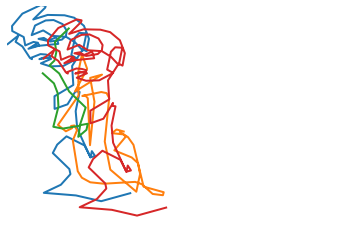

In [ ]:
plot_strokes(deltas_to_strokes(test_decoded))

In [ ]:
tokenizer.centroids_zero

array([[ 0.6209417 , -0.33721057,  0.        ],
       [-4.1855707 , -3.1003277 ,  0.        ],
       [ 5.7066207 ,  2.6960166 ,  0.        ],
       ...,
       [-1.1269675 , -0.28028095,  0.        ],
       [-3.6861207 , -4.5447764 ,  0.        ],
       [-1.6025403 ,  0.5354872 ,  0.        ]], dtype=float32)

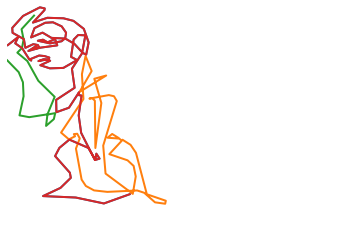

In [ ]:
plot_strokes(deltas_to_strokes(ds[2]))

In [ ]:
deltas_tmp = ds[2]

In [ ]:
deltas_tmp.shape

(242, 3)

In [ ]:
deltas_tmp[:5]

array([[ 0.3771549 , 38.41915779,  0.        ],
       [ 6.84299279, -8.26956107,  0.        ],
       [-1.94953761,  6.4101698 ,  0.        ],
       [ 4.55352531,  4.95268558,  0.        ],
       [ 4.70517464, 11.38796166,  0.        ]])

In [ ]:
D0, I0 = kmeans_zero.index.search(deltas_tmp, 1)
D1, I1 = kmeans_one.index.search(deltas_tmp, 1)

S0 = kmeans_zero.centroids[I0]
S1 = kmeans_one.centroids[I1]


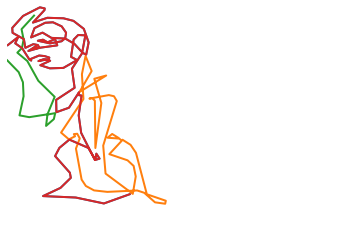

In [ ]:
plot_strokes(deltas_to_strokes(deltas_tmp))

In [ ]:
tokenized_steps = []
for idx in range(deltas_tmp.shape[0]):
    row = deltas_tmp[idx]
    if row[2] == 0:
        tokenized_steps.append(S0[idx][0])
    elif row[2] == 1:
        tokenized_steps.append(S1[idx][0])
    else:
        raise Exception ('didnt find a 0 or 1 in the lift_pen column')

new_deltas = np.array(tokenized_steps)

In [ ]:
new_deltas[0:5]

array([[-3.3815517, 40.04465  ,  0.       ],
       [ 6.9500613, -8.3709345,  0.       ],
       [-1.9793537,  6.5232167,  0.       ],
       [ 4.097289 ,  4.915239 ,  0.       ],
       [ 4.9076104, 11.547217 ,  0.       ]], dtype=float32)

In [ ]:
len(new_deltas)

242

In [ ]:
len(deltas_tmp)

242

#### TESTTT

In [ ]:
toks0 = [
    704, 1116, 1312,  418, 1892,  263,  701,  418,  985, 1161,  488,
         418, 1745,  418, 1310,  418,  985, 1788,  415,   42,  595, 1761, 1086,
        1727,  500,  766,  595,   42,  678,  458,  150,  278, 1029,  150, 1017,
        1541,  488,  595,  329,  755, 1745, 1541,  984,  488,  159, 1139, 1546,
         488,  415, 1761, 1835, 1310, 1310,  433,  259,  758, 1745,  150, 1029,
        1761,  521, 1903, 1203,  521,  150, 1310, 1809,   42, 1086,  415,  150,
         893, 1310, 1745,  150, 1745, 1029,  150,  758, 1310,  758, 1761, 1310,
         150,  320,  235, 1745,  415,  329, 1745, 1788, 1310,  208, 1310, 1310,
        1029,  488, 1310, 1086,  433, 1546, 1086, 1843,  150, 1029,  488, 1727,
         329, 1809, 1788, 1310, 1745, 1310, 1029, 1310, 1086,  433, 1029,  758,
         329, 1793,  329,  433,   30, 1745,  758, 1745, 1086,  595,  329, 1310,
         150,   30, 1310,  150, 1310, 1809, 1029,  278, 1310, 1086, 1843,  329,
         150,  899, 1745, 1310,  150,  329,  329,  755, 1310,  150,  150, 1761,
         755,  521,   30,  329,  433,  329, 1809, 1745,  758,  329, 1809, 1086,
         150,  500, 1310,  521, 1086, 1745,  291,  879,  568,  521, 1861, 1029,
        1310,  329,  433,  150,  899,  150, 1745, 1310,  290,  150,  329,  150,
         150,  893,  150, 1029,  150, 1310, 1745,  150,  329,  433, 1788,  534,
          30,  755, 1310,  290, 1086,  150, 1029, 1745,  415, 1809, 1029,  488,
         150, 1086,  150, 1745, 1788, 1358,  521, 1086, 1745, 1745, 1310, 1835,
        1310,  150, 1029, 1310, 1086,  150, 1310, 1086,  433, 1310, 1086, 1310,
        1086,  150,  534, 1475,  150, 1310, 1086,  150, 2087,  955, 1310,  150,
        1086,  766,  278, 1310
]

In [ ]:
toks1 = [
    80,  647, 1049, 1491, 1729,  686,  807, 1732, 1872, 1267,   42,
        1650, 1464, 1410, 2038, 1542, 1115, 1483, 1118,  355,  722, 1262, 1049,
         872,  975, 1348, 1799, 1438,  600, 1592,  884, 1592,  547, 1258, 1872,
         844,  118,   37, 1875, 1593, 1419, 2036, 1737,  263, 1624, 1032, 1879,
         695, 1474, 1043,  345, 1487,  120,  967,  458,  599, 1594, 1520, 1626,
         185, 1435, 1655,  847,  301,  894, 1570,  685,  599, 1594, 1520,  239,
         212, 2037, 1326, 1481, 1350,  861,  304,  975,  855, 1501, 1647, 1446,
        2044, 1412, 1627, 1613, 1446,  413, 1335, 2022, 1817,  135, 1804,  695,
        1566,  465, 1341, 1339,  127,  440, 1725,  950, 1975,  430, 1162, 1590,
        2005, 1569,  199, 1435,  790, 1640, 1561,  273,  185, 1134, 1474, 1043,
         345, 1336, 1649,  190, 1014, 1087,   69, 1917, 1420,  730, 1006, 1058,
         448, 1087, 1523, 1330, 1244, 1375, 1501,  828, 1979, 1311, 1875, 1593,
         872, 1099,  388, 1737,  141, 1049, 2009,  582, 1940, 1053, 2025,  272,
        1302, 1267, 1908, 1718, 1415, 1014,  929,  159, 1912, 1343, 1343,  212,
        1343,  123,  200, 2009,  855,  154, 1339,  154, 1490, 1100, 1760,  850,
        1640,  345,   37,    7, 1028, 1182, 1446, 1487, 1501,   51, 1613,  354,
         273, 1227, 1677, 1490, 1062, 1627, 1721, 1341, 2017, 1339,  675,  872,
         910,  441,  652,  828,   76, 1150,   58, 1691, 1905, 1595, 1797,  386,
         893,  256,  155,  212, 1343,  212, 1343,   45, 1878, 1542,   42, 1400,
        2090
]

In [ ]:
toks2 = [
    398, 1891, 1211, 1801, 1161, 1540,  526,  405,  377,  885,  309,
         985, 1836,  222,  214, 1626,  901, 1161, 1219, 1975, 1198, 1526,  809,
        1891, 1267, 1563,  405, 1989,  233, 1541,  343, 1199, 1401, 1098,  501,
         927, 1951, 1365, 1029, 1833, 1435,  316, 2021,  863, 1175,  855,  278,
         925, 1756,  241,  484,  617,  478,  165, 1687,  158, 1015,  252, 1868,
        1453,  253,  698,  722, 1170, 1888, 1802,  947, 1336,  692, 1268, 1732,
         772, 1207,  597, 1747,  386,  904,  850,  594,  855, 1192, 1668, 1240,
        1015,  174,  112,  118,  839,  263, 1294,  239,  467,  178,  253, 1577,
         547, 1229,  842,  674,  662,  828, 1364, 1049, 1318,  178,  467,   62,
         283, 1935, 1318, 1207,  562, 2007,  424, 1355, 1732,  647, 1287,   94,
         281, 1217, 1936,  343,  851, 1487, 2062
]

In [ ]:
toks2 = [
    290, 1725,  936,  743,  574,  381,  599, 1005,  799, 1129,   86,
         966, 1436,  778, 2000,  140, 1571, 2014, 1680, 1091,  364,  236,  270,
        1136,  803,  648,   81,  315, 1021, 1954, 1660,  474, 1440, 1043,  898,
        1528,  381,  407,  407, 1431,  192,  921, 1636, 1847,   17,  177,  969,
        1725,  140, 1945, 1596,  925, 1986, 1967,  648, 1991, 1400,  523,  157,
         601,  342,  321, 1914, 1890,  342,  504,  623,  221, 1244,  379,   86,
         131,  224,   24,  585,  729, 1880, 1044, 1287,  624, 1145, 1484, 1355,
         435,   24,  537,   86, 1027, 1332, 1037,   69, 1254, 1257,  165,  946,
          55,  601,  485,  168,  771, 2028, 1195, 1389,  589, 1725,  986, 1805,
        1156,  192,  894, 1117,  506,  321, 1175, 1255,  232, 1351, 1363, 1204,
          87,  525, 1541, 1931, 2006,  856,  301, 1557,  808,  146,  815, 1210,
         341,  713,  255,  959,  813,  376,  616, 1485, 1738,  584,  893,  629,
         804, 1897, 1294, 1617,  370, 1175,  363,  643, 1439, 2096
]

In [ ]:
toks2 = [
    290, 1627,  815,  434, 1528, 1634, 1223,  818, 1914, 1303,  349,
         770, 1683,  648, 1654,  649,  254,  903, 1203, 1950, 1531, 1094, 1449,
          59,  614,  370,  980,  741,  563,   12, 1739, 1537, 1620,   11,  463,
        1605, 1518,  364, 1562, 1739, 1038, 1976, 1356, 1530,   12, 1734,  792,
        1181,  134,  426, 1990, 2029, 1348, 1785,  471,  171,  804,  589,  811,
        1108,  563, 1947,  712, 1976, 1502,  537, 1748, 1785, 1487, 1986, 1512,
        1006, 1005,  342, 1511, 1962, 1292,  858,  246, 1943, 1540, 1198, 1623,
         876, 1540,  622, 1321,  884, 1010,  255,  295,  627, 1367, 1003, 1585,
        1701, 1185, 1175,  232, 1601,  818,  474, 1390,  624, 1634, 1261,  379,
         108, 1893, 1793, 1077, 1693,  829, 1966,  192, 1145, 1542,  779, 1084,
         452,  556,  643, 1116, 1951,  265,  394,  157, 1900, 1945, 1277, 1966,
        1542, 1614, 1951, 1470,  672, 1790,   86,  380, 1245, 1449,  379,  831,
        1409, 1824, 1955,  379, 1003,   55, 1084,  452,  208, 1972,  847, 1151,
         585,  560, 1227,  648,  537, 1175, 1477, 1614,  324,  384,  272,  574,
        1448,  422,  771,  992, 1255, 1150, 1391,  617, 1400,  304, 1998,  997,
        1735, 1337, 1712,  402, 2090
]

In [ ]:
# toks2 = [290, 1725,  936,  743,  574,  381,  599, 1005]
toks2 = [
    56,  562, 1168,  728,  915,  323, 1184,  572, 1375,  598,  765,
        1375, 1317, 1761,   79, 1028,  219, 1719,  733,  226, 1872,  531, 1142,
        1977, 1450,   79, 1753,  628,  694, 1670, 1071,  612,   79, 1630,  754,
         301,  172, 1548, 1339,  179, 1188,  633,  707, 1339, 1816,  695, 1235,
        1053,  602, 1465,  802, 1872,  553, 1521, 1592, 1393, 1137, 1492,   60,
        1067,  805, 1951,  274,  596, 1457,  473, 2009, 1078, 2025,  388, 1193,
         362, 1801, 1853, 1296, 1493,  110,  643,  338, 1147, 1503, 1687,  536,
        1045,  760,  647, 1365, 1600, 1900,  243,  622,  237,   18, 2032,  304,
        1503, 1342,    8, 1238,  650, 1183,  969,  185, 1067,   74, 1155,  469,
         836, 1459, 1606, 1481, 1850, 1475,  914,  297,  713,  671,  600,  815,
          58, 2036, 1867,  193,  970,  543,  590,  612, 1768, 1417, 1882, 1061,
        1474,  161, 1764, 1998, 1229,  522, 1402,  279,  668, 2037,  438,  233,
        1086, 2016,  915,  683,  564,  412, 1555,  407, 1326, 1784, 1450,  409,
        1025,  517, 1778,  498, 1519,  728,  990, 1575,  469,  610, 2039, 1678,
         299, 1810,   20, 1125,  161, 1921,  751, 2027, 1779, 1230, 2037, 1083,
        1148,  339, 2009, 1938, 2039,  395, 1639,  975, 1548, 2032, 1630,   79,
         667, 1554, 1867,  439,  872,  474,  658, 1893, 1029,  193,  168, 1308,
        1844,  650, 1545,  251,  325, 1515, 1839,  460, 1350, 1427,  355, 1878,
        1609, 1537, 1692,  304,  301, 1928, 1289,  164, 1545,  156, 1213,  540,
         193,  766, 2088
]

In [ ]:
toks2 = [
    56,  562, 1168,  728,  915,  323, 1184,  572, 1375,  598,  765,
        1375, 1317, 1761,   79, 1028,  219, 1719,  733,  226, 1872,  531, 1142,
        1977, 1450,   79, 1753,  628,  694, 1670, 1071,  612,   79, 1630,  754,
         301,  172, 1548, 1339,  179, 1188,  633,  707, 1339, 1816,  695, 1235,
        1053,  602, 1465,  802, 1872,  553, 1521, 1592, 1393, 1137, 1492,   60,
        1067,  805, 1951,  274,  596, 1457,  473, 2009, 1078, 2025,  388, 1193,
         362, 1801, 1853, 1296, 1493,  110,  643,  338, 1147, 1503, 1687,  536,
        1045,  760,  647, 1365, 1600, 1900,  243,  622,  237,   18, 2032,  304,
        1503, 1342,    8, 1238,  650, 1183,  969,  185, 1067,   74, 1155,  469,
         836, 1459, 1606, 1481, 1850, 1475,  914,  297,  713,  671,  600,  815,
          58, 2036, 1867,  193,  970,  543,  590,  612, 1768, 1417, 1882, 1061,
        1474,  161, 1764, 1998, 1229,  522, 1402,  279,  668, 2037,  438,  233,
        1086, 2016,  915,  683,  564,  412, 1555,  407, 1326, 1784, 1450,  409,
        1025,  517, 1778,  498, 1519,  728,  990, 1575,  469,  610, 2039, 1678,
         299, 1810,   20, 1125,  161, 1921,  751, 2027, 1779, 1230, 2037, 1083,
        1148,  339, 2009, 1938, 2039,  395, 1639,  975, 1548, 2032, 1630,   79,
         667, 1554, 1867,  439,  872,  474,  658, 1893, 1029,  193,  168, 1308,
        1844,  650, 1545,  251,  325, 1515, 1839,  460, 1350, 1427,  355, 1878,
        1609, 1537, 1692,  304,  301, 1928, 1289,  164, 1545,  156, 1213,  540,
         193,  766, 2088
]

In [ ]:
toks2 = [
    398, 1970, 1645, 1757,  845,  145, 1987,  975, 1166, 1306,  715,
          87,  166,   84,  701,  225, 1972,  617, 2024, 1610, 1876,  702,  430,
        1944,  104, 1226,  885, 1763, 1294,  119,  418, 1194,  306, 1484, 1201,
        1355, 1404,   40, 1787,  274, 1787, 1536, 1447,  966, 1404, 1219,   61,
          99, 1944,  685, 1226, 1833,  808,  685, 1613, 1595,  966,  903,   99,
         944,  407,  702,   14,  178, 1147, 1139, 1400,  307,  130, 1764, 1660,
        1607,  313,  288, 1488, 1686, 1074, 1170, 1035,  283,  278,  617, 1755,
         568,  488,  418,  502,   16, 1710, 1704,  627, 1025,  988, 1371,  502,
         932,  439, 1991,  480, 1973, 1441, 1488,  475,  241, 1005,  988, 1598,
         905,  698, 1901, 1569,  616,  463, 1940, 1432, 1868,  944,  544, 1059,
        2030, 1887,   19,  779, 1763, 1879, 1281, 1504, 1373, 1043, 1826,   40,
         616, 1177,  158,  119,  225,  740,  793,  698,  905,  881, 1422,   68,
        1750,  698,  709, 1815,  307,  954, 1907,  697,   40, 1292, 1787, 1447,
        1441, 1070, 1197, 1219, 1958,  906,  513,  186,   87,  960,  938, 1360,
        1944,   18,  404,  778,  740,  663, 2030, 2042, 1710, 1178,  222,  627,
          99, 1947,  361,  444, 1470,  283,   84,  517, 1973,  815,  553,  104,
        1660,  988,  636,  836, 1294, 1698,  634, 1064, 1292, 1046, 1580,  634,
        1515,  225, 1633, 1242, 1897, 1180, 1217, 1702, 1884,  881,  439,  709,
        1675, 1292, 1474,  345, 1927,  184,  698, 1771,  666,  462, 1978,  176,
        2012, 1676,   40, 1040,  616, 1973,  372, 1970,  839,  222, 1373,  493,
          18, 1043, 1441, 1320, 1219, 2089
]

In [ ]:
toks2 = [398, 1970, 1645, 1757]
toks2 = [
    398, 1970, 1645, 1757,  845,  145, 1987,  975, 1166, 1306,  715,
          87,  166,   84,  701,  225, 1972,  617, 2024, 1610, 1876,  702,  430,
        1944,  104, 1226,  885, 1763, 1294,  119,  418, 1194,  306, 1484, 1201,
        1355, 1404,   40, 1787,  274, 1787, 1536, 1447,  966, 1404, 1219,   61,
          99, 1944,  685, 1226, 1833,  808,  685, 1613, 1595,  966,  903,   99,
         944,  407,  702,   14,  178, 1147, 1139, 1400,  307,  130, 1764, 1660,
        1607,  313,  288, 1488, 1686, 1074, 1170, 1035,  283,  278,  617, 1755,
         568,  488,  418,  502,   16, 1710, 1704,  627, 1025,  988, 1371,  502,
         932,  439, 1991,  480, 1973, 1441, 1488,  475,  241, 1005,  988, 1598,
         905,  698, 1901, 1569,  616,  463, 1940, 1432, 1868,  944,  544, 1059,
        2030, 1887,   19,  779, 1763, 1879, 1281, 1504, 1373, 1043, 1826,   40,
         616, 1177,  158,  119,  225,  740,  793,  698,  905,  881, 1422,   68,
        1750,  698,  709, 1815,  307,  954, 1907,  697,   40, 1292, 1787, 1447,
        1441, 1070, 1197, 1219, 1958,  906,  513,  186,   87,  960,  938, 1360,
        1944,   18,  404,  778,  740,  663, 2030, 2042, 1710, 1178,  222,  627,
          99, 1947,  361,  444, 1470,  283,   84,  517, 1973,  815,  553,  104,
        1660,  988,  636,  836, 1294, 1698,  634, 1064, 1292, 1046, 1580,  634,
        1515,  225, 1633, 1242, 1897, 1180, 1217, 1702, 1884,  881,  439,  709,
        1675, 1292, 1474,  345, 1927,  184,  698, 1771,  666,  462, 1978,  176,
        2012, 1676,   40, 1040,  616, 1973,  372, 1970,  839,  222, 1373,  493,
          18, 1043, 1441, 1320, 1219, 2089
]

In [ ]:
deltas2 = tokenizer.decode(toks2)
points2 = deltas_to_points(deltas2)

from singleline_stroke3.transforms import *

bb2 = BoundingBox.create(points2)

In [ ]:
bb2.normalization_xform()

array([[0.00503905, 0.        , 0.0834106 ],
       [0.        , 0.00503905, 0.0439159 ],
       [0.        , 0.        , 1.        ]])

In [ ]:
points2[:5]

array([[ 25.145422 , 101.08444  ,   0.       ],
       [ 18.600489 ,  96.81329  ,   0.       ],
       [  6.7933865,  87.587166 ,   0.       ],
       [  4.1127415,  81.01716  ,   0.       ],
       [ 16.204659 ,  72.208855 ,   0.       ]], dtype=float32)

In [ ]:
normed_points2 = apply_transform(points2[:,:2], bb2.normalization_xform(scale=200.0))

In [ ]:
normed_points2[:,2] = points2[:,2]

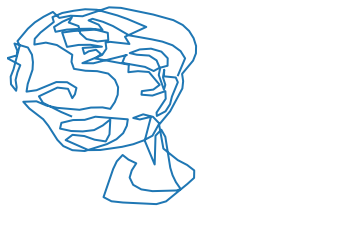

In [ ]:
plot_strokes(points_to_strokes(normed_points2))

In [ ]:
# #| hide
# import nbdev

# nbdev.nbdev_export()